In [1]:
sc.master

u'local[*]'

In [2]:
global Path    
if sc.master[0:5]=="local" :
   Path="file:/home/hduser/pythonwork/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"

In [3]:
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"SAheart.csv")
rawDataWithHeader.take(2)

開始匯入資料...


[u'row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd',
 u'1,160,12.00, 5.73,23.11,Present,49,25.30, 97.20,52,1']

In [4]:
header = rawDataWithHeader.first() 
rData = rawDataWithHeader.filter(lambda x:x !=header)  
lines = rData.map(lambda x: x.split(","))
print("共計：" + str(lines.count()) + "筆")

共計：462筆


In [5]:
lines.take(1)

[[u'1',
  u'160',
  u'12.00',
  u' 5.73',
  u'23.11',
  u'Present',
  u'49',
  u'25.30',
  u' 97.20',
  u'52',
  u'1']]

In [6]:
import numpy as np
def extract_features(field,featureEnd):
    #擷取分類特徵欄位
       #第3个欄位不是特徵欄位
    numericalFeatures=[float(id)  for  id in field[0:2]]    
    #回傳「分類特徵欄位」
    return numericalFeatures


def extract_label(field):
    label=(field[-1])
    return float(label)

In [7]:
labelRDD = lines.map( lambda r: extract_label(r))
print labelRDD.collect()

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,

In [8]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,len(r) - 1)))

In [9]:
labelpointRDD.take(2)
trainData=labelpointRDD
trainData.persist()

PythonRDD[8] at RDD at PythonRDD.scala:48

In [10]:
###from pyspark.mllib.tree import DecisionTree
###model=DecisionTree.trainClassifier( \
###        trainData, numClasses=2, categoricalFeaturesInfo={}, \
###        impurity="entropy", maxDepth=5, maxBins=5)

In [11]:
###predictResult = model.predict([-25,2.5,0.5])  ###(X1,X2,X3) = [-25,2.5,0.5]

In [12]:
###predictResult

In [13]:
  #-----------3.以隨機方式將資料分為3部份並且回傳-------------
(trainData, validationData, testData) = labelpointRDD.randomSplit([6, 2, 2])
print("trainData:" + str(trainData.count()) +   
            "   validationData:" + str(validationData.count()) + 
            "   testData:" + str(testData.count()))



trainData:285   validationData:98   testData:79


In [14]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[14] at RDD at PythonRDD.scala:48

In [15]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time

# print out the comparison of true & prediction 
def PredictData(RDD,model): 
    for data in RDD.take(5):
        predictResult = model.predict(data.features)
        print " True label：  " +str(data.label)+"\n" +\
                  "             ==>Predict label:"+ str(predictResult)

# get the AUC score of a given model
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return (AUC)

# build model with the given parameters & get the AUC score
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

# try different group of parameters & return the best model
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    

    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n"+"AUC = " + str(bestParameter[0]))
    return bestParameter[5]

In [16]:
# performance on validation data
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)
print("validationData,  AUC: " + str(AUC))

validationData,  AUC: 0.493740972557


In [17]:
# performance on test data
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)
print("testData,  AUC: " + str(AUC))

testData,  AUC: 0.52908496732


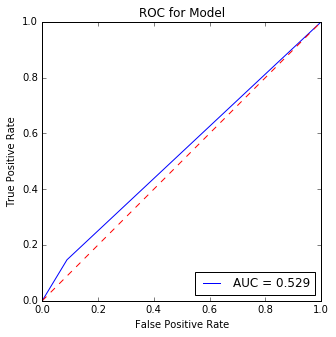

In [18]:
from sklearn import metrics
import warnings;warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 

y = [ i.label for i in testData.collect()]
pred = [model.predict(i.features) for i in testData.collect()]

fpr, tpr, threshold = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC for Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')  # (0,0) (1,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# model -> predict -> evaluate

In [19]:
print("-----所有參數訓練評估找出最好的參數組合---------")  
bestModel=evalAllParameter(trainData, validationData,
                        ["gini", "entropy"],
                        [3, 5, 10, 15, 20, 25], 
                        [3, 5, 10, 15, 20, 25])

-----所有參數訓練評估找出最好的參數組合---------
調校後最佳參數：impurity:gini,maxDepth:3,maxBins:20
AUC = 0.554405392393


In [20]:
AUC=evaluateModel(bestModel, testData)
print "AUC = "+str(AUC)
print "\n"
print("-----預測資料-----")
PredictData(testData,bestModel)

AUC = 0.547385620915


-----預測資料-----
 True label：  1.0
             ==>Predict label:0.0
 True label：  1.0
             ==>Predict label:0.0
 True label：  1.0
             ==>Predict label:0.0
 True label：  0.0
             ==>Predict label:0.0
 True label：  1.0
             ==>Predict label:0.0


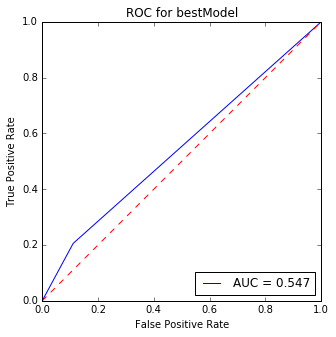

In [21]:
from sklearn import metrics
import warnings;warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 

y = [ i.label for i in testData.collect()]
pred = [bestModel.predict(i.features) for i in testData.collect()]

fpr, tpr, threshold = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC for bestModel')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')  # (0,0) (1,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()